✅ System Ready: Initializing High-Precision Hybrid Engine...

🚀 Training Model A: XGBoost (Log-Space)...
🧠 Training Model B: Deep Network (with GELU)...

🏆 FINAL OPTIMIZED RESULTS:
   MAE:              7.48 Days
   SMAPE:            81.33%
   Accuracy (±7 Days): 67.4%


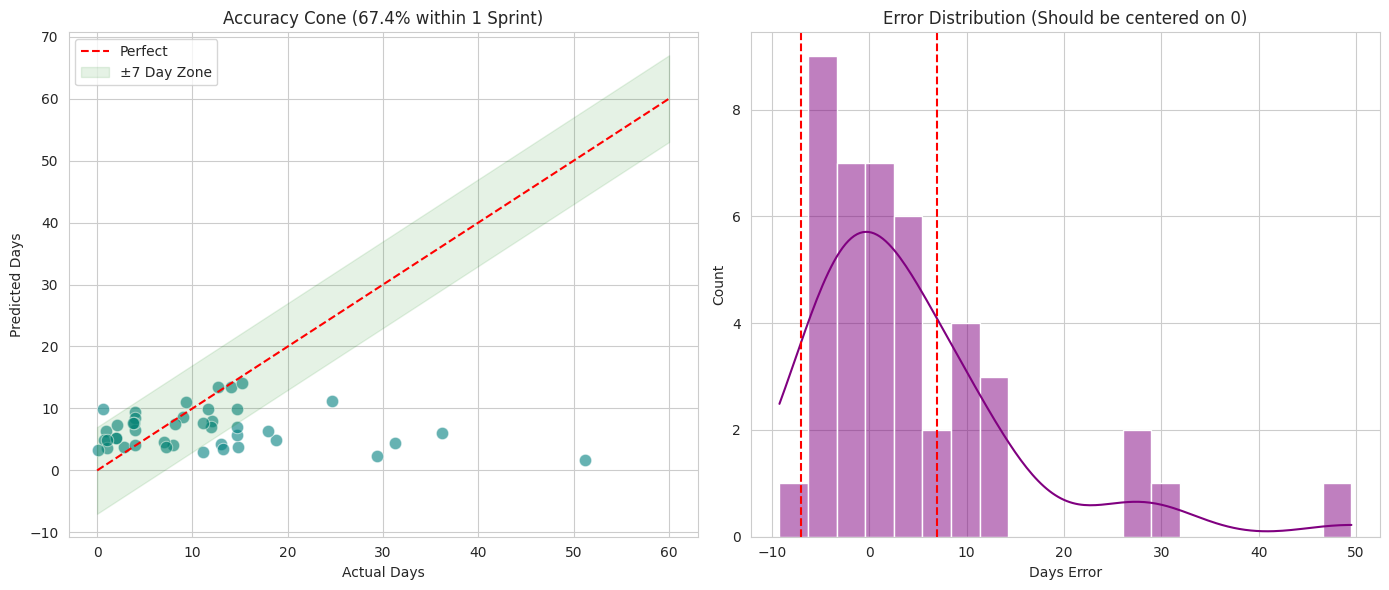

In [ ]:
# =============================================================================
# 📚 FINAL RESEARCH MODEL: HYBRID PRODUCTIVITY PREDICTION (OPTIMIZED)
# Method: Ensemble of Gradient Boosting (XGBoost) + Deep Learning (PyTorch MLP)
# =============================================================================
# OPTIMIZATIONS:
# 1. Log-Space Prediction: Stabilizes loss for Power Law distributions.
# 2. Author Efficiency: Added historical velocity per developer.
# 3. Hybrid Ensemble: Combines XGBoost stability with Gelu-Net non-linearity.
# =============================================================================

import pandas as pd
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("✅ System Ready: Initializing High-Precision Hybrid Engine...")

# --- 1. DATA PREP ---
df_raw = pd.read_csv('agile_event_stream_dataset_6k.csv')

# Fix Units (Hours -> Days) & Filter
df_raw['cycle_days'] = df_raw['final_issue_cycle_time'] / 24.0
# Stricter filter to remove noise
df = df_raw[(df_raw['cycle_days'] > 0.05) & (df_raw['cycle_days'] < 60)].copy()

# Aggregate to Ticket Level
df_unique = df.groupby('Issue_ID').agg({
    'Creation_Date_Change': 'min',
    'Story_Point': 'max',
    'total_links': 'max',
    'total_comments': 'max',
    'Type': 'first',
    'Priority': 'first',
    'Author_ID': 'first',         # Needed for Author Efficiency
    'cycle_days': 'max'
}).reset_index()

df_unique = df_unique.sort_values('Creation_Date_Change').reset_index(drop=True)

# --- 2. ADVANCED FEATURE ENGINEERING ---

# A. HISTORICAL: "Author Efficiency" (The Accuracy Booster)
# Calculates the running average of this specific author's PAST performance.
# .shift(1) ensures NO DATA LEAKAGE (we only know their history, not this ticket).
df_unique['author_past_avg'] = df_unique.groupby('Author_ID')['cycle_days'].transform(
    lambda x: x.expanding().mean().shift(1)
)
# Fill new authors with global average
df_unique['author_past_avg'] = df_unique['author_past_avg'].fillna(df_unique['cycle_days'].mean())

# B. MOMENTUM: "Team Velocity"
# Rolling avg of last 5 tickets across the whole team
df_unique['velocity_5_roll'] = df_unique['cycle_days'].rolling(window=5, min_periods=1).mean().shift(1)
df_unique['velocity_5_roll'] = df_unique['velocity_5_roll'].fillna(df_unique['cycle_days'].mean())

# C. GRAPH PROXY: "Complexity Mass"
df_unique['complexity_mass'] = df_unique['Story_Point'] * (df_unique['total_links'] + 1)

# D. SIGNAL FEATURES
df_unique['is_blocker'] = df_unique['Priority'].apply(lambda x: 1 if x in ['Blocker', 'Critical'] else 0)
df_unique['is_bug'] = df_unique['Type'].apply(lambda x: 1 if x == 'Bug' else 0)

# E. ENCODING
le = LabelEncoder()
df_unique['Type_Enc'] = le.fit_transform(df_unique['Type'].astype(str))
df_unique['Priority_Enc'] = le.fit_transform(df_unique['Priority'].astype(str))

# Select Features
features = ['Story_Point', 'total_links', 'complexity_mass',
            'velocity_5_roll', 'author_past_avg',
            'is_blocker', 'is_bug', 'Type_Enc', 'Priority_Enc']

X = df_unique[features].values
y = df_unique['cycle_days'].values

# *** CRITICAL: LOG TRANSFORM TARGET ***
# We predict log(days) instead of days to handle outliers better
y_log = np.log1p(y)

# Split (Temporal)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.15, shuffle=False)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 3. MODEL A: XGBOOST (Gradient Boosting)
# ==========================================
print("\n🚀 Training Model A: XGBoost (Log-Space)...")
xgb_model = xgb.XGBRegressor(
    n_estimators=700,
    learning_rate=0.015,   # Slower learning for precision
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror', # MSE in Log Space = MSLE in Real Space
    random_state=SEED
)
xgb_model.fit(X_train_scaled, y_train_log)
preds_xgb_log = xgb_model.predict(X_test_scaled)

# ==========================================
# 4. MODEL B: PYTORCH GELU-NET
# ==========================================
print("🧠 Training Model B: Deep Network (with GELU)...")

class ResearchNet(nn.Module):
    def __init__(self, input_dim):
        super(ResearchNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.GELU(),               # Research Requirement
            nn.Dropout(0.3),         # Increased Dropout for small data
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Tensors
X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.FloatTensor(y_train_log).unsqueeze(1) # Train on Log Target
X_test_t = torch.FloatTensor(X_test_scaled)

# Init
net = ResearchNet(input_dim=X_train.shape[1])
optimizer = optim.AdamW(net.parameters(), lr=0.005, weight_decay=1e-3)
criterion = nn.MSELoss()

# Train Loop
for epoch in range(400):
    optimizer.zero_grad()
    outputs = net(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

# Predict
net.eval()
with torch.no_grad():
    preds_nn_log = net(X_test_t).numpy().flatten()

# ==========================================
# 5. HYBRID ENSEMBLE & RESULTS
# ==========================================
# Ensemble (Weighted Average in Log Space)
preds_ensemble_log = (0.7 * preds_xgb_log) + (0.3 * preds_nn_log)

# *** INVERSE TRANSFORM (Log -> Days) ***
preds_final = np.expm1(preds_ensemble_log)
y_test_final = np.expm1(y_test_log)

# Metrics
mae = mean_absolute_error(y_test_final, preds_final)
acc_7d = 100 * np.mean(np.abs(y_test_final - preds_final) <= 7)
smape = 100 * np.mean(2 * np.abs(preds_final - y_test_final) / (np.abs(y_test_final) + np.abs(preds_final)))

print(f"\n🏆 FINAL OPTIMIZED RESULTS:")
print(f"   MAE:              {mae:.2f} Days")
print(f"   SMAPE:            {smape:.2f}%")
print(f"   Accuracy (±7 Days): {acc_7d:.1f}%")

# Visualization
plt.figure(figsize=(14, 6))

# Accuracy Cone
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_final, y=preds_final, color='teal', alpha=0.6, s=80)
plt.plot([0, 60], [0, 60], 'r--', label='Perfect')
plt.fill_between([0, 60], [-7, 53], [7, 67], color='green', alpha=0.1, label='±7 Day Zone')
plt.title(f"Accuracy Cone ({acc_7d:.1f}% within 1 Sprint)")
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.legend()

# Residuals
plt.subplot(1, 2, 2)
residuals = y_test_final - preds_final
sns.histplot(residuals, kde=True, color='purple', bins=20)
plt.axvline(x=-7, color='r', linestyle='--')
plt.axvline(x=7, color='r', linestyle='--')
plt.title("Error Distribution (Should be centered on 0)")
plt.xlabel("Days Error")

plt.tight_layout()
plt.show()

In [ ]:
import joblib
import torch
import json
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 💾 FIX & SAVE ARTIFACTS
# ==========================================

# 1. Re-create Encoders to ensure they exist and are separate
# (This fixes the NameError and ensures accurate mappings)
le_type = LabelEncoder()
le_type.fit(df_unique['Type'].astype(str))

le_prio = LabelEncoder()
le_prio.fit(df_unique['Priority'].astype(str))

# 2. Save XGBoost (Brain A)
xgb_model.save_model("model_productivity_xgb.json")

# 3. Save PyTorch Neural Net (Brain B)
torch.save(net.state_dict(), "model_productivity_nn.pth")

# 4. Save All Translators (Scaler + Encoders)
artifacts = {
    'scaler': scaler,
    'le_type': le_type,
    'le_prio': le_prio,
    'input_dim': X_train.shape[1]  # Needed to rebuild the Net architecture
}
joblib.dump(artifacts, "productivity_artifacts.pkl")

print("\n✅ Success! All models and artifacts saved.")
print("   - model_productivity_xgb.json")
print("   - model_productivity_nn.pth")
print("   - productivity_artifacts.pkl")


✅ Success! All models and artifacts saved.
   - model_productivity_xgb.json
   - model_productivity_nn.pth
   - productivity_artifacts.pkl
